In [198]:
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
import re
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns 

%matplotlib inline

In [27]:
#Using the List of Controversial Issues page, grab names of all of the controversial topics on Wikipedia 
html = urlopen('https://en.wikipedia.org/wiki/Wikipedia:List_of_controversial_issues')
bs = BeautifulSoup(html, 'html.parser')
allLinks = []
various_not_allowed = ['Wikipedia', '%', 'http', 'www']
for link in bs.find_all('a'):
    if 'href' in link.attrs:
        if 'wiki' in link.attrs['href']:
            if various_not_allowed[0] not in link.attrs['href']:
                if various_not_allowed[1] not in link.attrs['href']:
                    if various_not_allowed[2] not in link.attrs['href']:
                        if various_not_allowed[3] not in link.attrs['href']:
                            allLinks.append(link.attrs['href'])
del allLinks[0]
allLinks = allLinks[:-26]
print(allLinks)

['/wiki/2003_invasion_of_Iraq', '/wiki/Abortion', '/wiki/Affirmative_action', '/wiki/African_National_Congress', '/wiki/Alberta', '/wiki/American_Civil_Liberties_Union', '/wiki/American_Hunters_and_Shooters_Association', '/wiki/History_of_the_Jews_in_the_United_States', '/wiki/American_Jews', '/wiki/Anarchism', '/wiki/Anarcho-capitalism', '/wiki/Anti-Americanism', '/wiki/Anti-clericalism', '/wiki/Anti-Irish_racism', '/wiki/Anti-semitism', '/wiki/Asian_American', '/wiki/Atheism', '/wiki/Austrian_School', '/wiki/Bashar_Assad', '/wiki/Syrian_Civil_War', '/wiki/Bidoon_(social_class)', '/wiki/Black_Lives_Matter', '/wiki/Black_supremacy', '/wiki/Boricua_Popular_Army', '/wiki/Brexit', '/wiki/British_National_Party', '/wiki/Capitalism', '/wiki/Capital_punishment', '/wiki/Catalonia', '/wiki/Cherokee', '/wiki/China', '/wiki/East_Turkestan_Independence_Movement', '/wiki/Tibetan_independence_movement', '/wiki/Human_rights_in_China', '/wiki/Chinese_intelligence_activity_abroad', '/wiki/Christian_ri

In [147]:
#This function grabs the change request history for any give page. 
def grab_all_history(url, topic, df_all_history):
    link_still_there = True
    # While statement loops through all pages of the change history
    while link_still_there:
        html = urlopen(url)
        bs = BeautifulSoup(html, 'html.parser')
        # Changes are in <li>, but not all li
        for li_tag in bs.find_all('li'):
            tags = []
            has_no_comment = True
            first_tag_comment = True
            line_for_append = [url, topic]
            # data-mw-revid begins the insert for each change
            if 'data-mw-revid' in li_tag.attrs:
                # dates and user names exist inside of <a> tags
                for a_tag in li_tag.find_all('a'):
                    # Date
                    if str(a_tag).__contains__('mw-changeslist-date'):
                        splits = re.split('>', str(a_tag))
                        line_for_append.append(splits[1][:-3])
                    # User
                    if str(a_tag).__contains__('mw-userlink'):
                        line_for_append.append(str(a_tag.attrs['href'])[6:])
                # All other data exists inside of <span> tags
                for span_tag in li_tag.find_all('span'):
                    # Bytes
                    if str(span_tag).__contains__('data-mw-bytes'):
                        splits = re.split('>', str(span_tag))
                        line_for_append.append(splits[1][:-12])
                    # Number of changes
                    if str(span_tag).__contains__('mw-plusminus'):
                        splits = re.split('>', str(span_tag))
                        line_for_append.append(splits[1][:-6])
                    # Comments
                    if str(span_tag).__contains__('comment') and has_no_comment:
                        if str(span_tag).__contains__('autocomment'):
                            splits = re.split('>', str(span_tag))
                            line_for_append.append("autocomment:" + splits[4][1:-3])
                            has_no_comment = False
                        else:
                            if str(span_tag).__contains__('href'):
                                line_for_append.append('manual comment: ' + str(span_tag)[51:-7])
                            else:
                                splits = re.split('>', str(span_tag))
                                line_for_append.append('manual comment: ' + splits[1][:-6])
                            has_no_comment = False
                    # Tags
                    if str(span_tag).__contains__('mw-tag-marker'):
                        if first_tag_comment:
                            first_tag_comment = False
                        else:
                            splits = re.split('>', str(span_tag))
                            if str(span_tag).__contains__('href'):
                                tags.append(splits[-3][:-3])
                            else:
                                tags.append(splits[-2][:-6])
                # In the case that there are no comments
                if has_no_comment:
                    line_for_append.append("No comment")
            line_for_append.append(tags)
            # add line to dataframe
            try:
                df_all_history.loc[len(df_all_history)] = line_for_append
            except:
                continue
        url = ''
        # Get next page of history
        for a_tag in bs.find_all('a'):
            if str(a_tag).__contains__('mw-nextlink'):
                url = 'https://en.wikipedia.org' + str(a_tag.attrs['href'])
                print(url)
        # If no next page, break while loop
        if url == '':
            link_still_there = False 
    return(df_all_history)

#This logic only here if running this cell alone. Otherwise, run below
url = 'https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history'
topic = 'List of Controversial Issues'
df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags'])
df_all_history = grab_all_history(url, topic, df_all_history)

In [150]:
#url = 'https://en.wikipedia.org/w/index.php?title=Wikipedia:List_of_controversial_issues&action=history'
#topic = 'List of Controversial Issues'
#df_all_history = pd.DataFrame(columns=['Page', 'Topic', 'Date of Change', 'User', 'Bytes', 'Number of Changes', 'Comments', 'Tags'])
#df_all_history = grab_all_history(url, topic, df_all_history)

#Run through every controversial topic, and grab change history
for topic in allLinks:
    print('https://en.wikipedia.org/w/index.php?title=' + topic[6:] + '&action=history')
    url = 'https://en.wikipedia.org/w/index.php?title=:' + topic[6:] + '&action=history'
    topic = topic[6:]
    df_all_history = grab_all_history(url, topic, df_all_history)
df_all_history.shape

https://en.wikipedia.org/w/index.php?title=2003_invasion_of_Iraq&action=history
https://en.wikipedia.org/w/index.php?title=Abortion&action=history
https://en.wikipedia.org/w/index.php?title=Affirmative_action&action=history
https://en.wikipedia.org/w/index.php?title=African_National_Congress&action=history
https://en.wikipedia.org/w/index.php?title=Alberta&action=history
https://en.wikipedia.org/w/index.php?title=American_Civil_Liberties_Union&action=history
https://en.wikipedia.org/w/index.php?title=American_Hunters_and_Shooters_Association&action=history
https://en.wikipedia.org/w/index.php?title=History_of_the_Jews_in_the_United_States&action=history
https://en.wikipedia.org/w/index.php?title=American_Jews&action=history
https://en.wikipedia.org/w/index.php?title=Anarchism&action=history
https://en.wikipedia.org/w/index.php?title=Anarcho-capitalism&action=history
https://en.wikipedia.org/w/index.php?title=Anti-Americanism&action=history
https://en.wikipedia.org/w/index.php?title=Ant

KeyboardInterrupt: 

In [157]:
df_all_history.head()
#df_all_history.shape

,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags
0,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"05:46, 11 January 2021",Special:Contributions/2600:1017:B01E:7ACC:9867...,"49,511",+31,autocomment:‎Entertainment,"[Mobile edit, Mobile web edit]"
1,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"02:36, 4 December 2020",Special:Contributions/2405:7F00:980D:2A00:8996...,"49,480",+20,No comment,[]
2,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"17:24, 28 October 2020",User:Jmg38,"49,460",−1,autocomment:‎People,[]
3,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"18:49, 28 September 2020",User:Northern_Moonlight,"49,461",−6,"autocomment:‎Sex, sexuality, and gender identity",[]
4,https://en.wikipedia.org/w/index.php?title=Wik...,List of Controversial Issues,"03:24, 22 September 2020",User:Clayoquot,"49,467",−25,autocomment:‎Environment,[]


In [152]:
df_all_history.to_csv('wikipedia_controversial.csv')

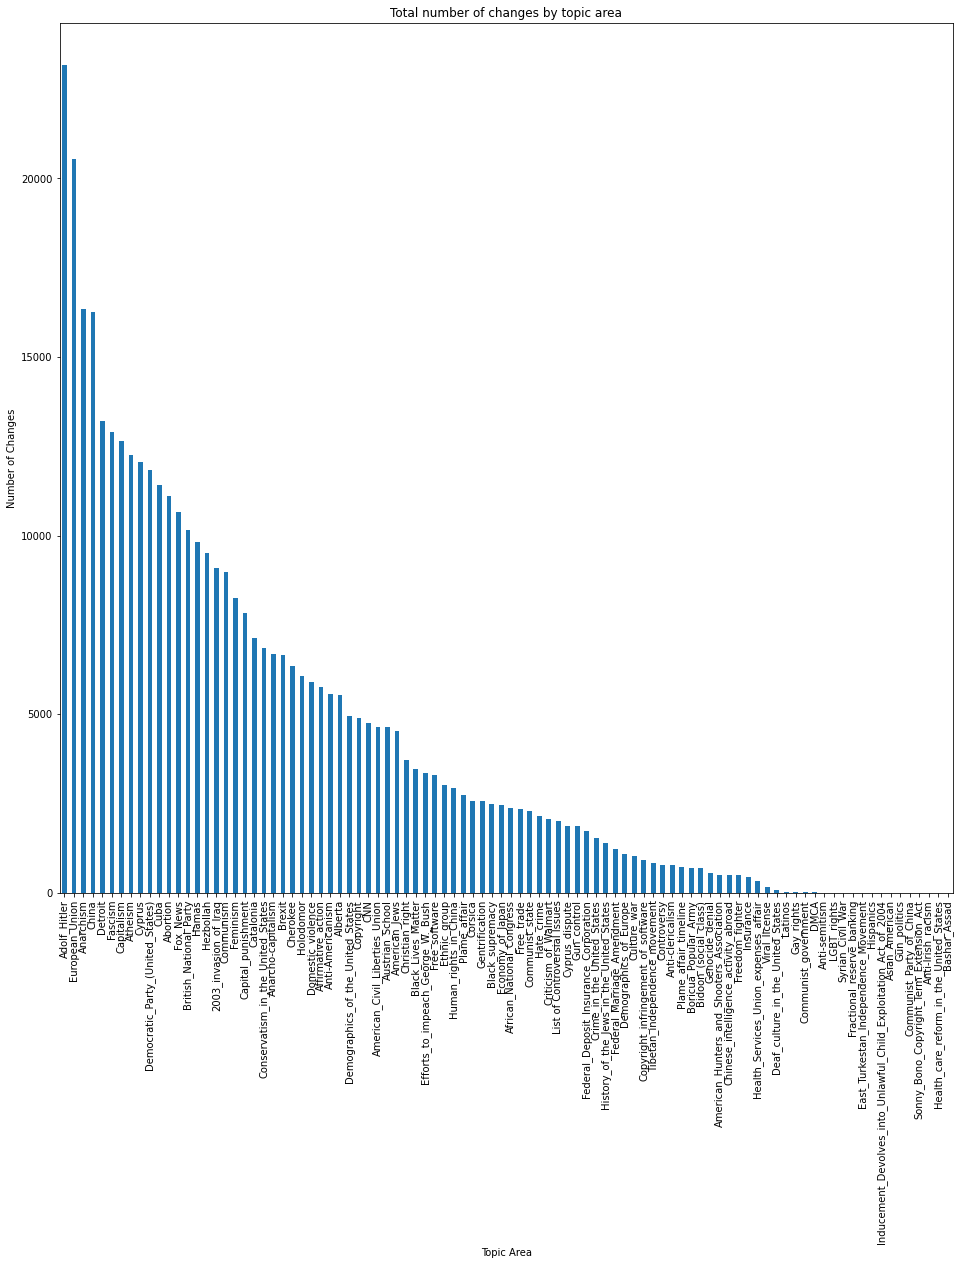

In [158]:
df_all_history['Topic'].value_counts().plot(kind='bar',
                             figsize=(16,16),
                             title='Total number of changes by topic area')
plt.xlabel('Topic Area')
plt.ylabel('Number of Changes');
# There are even controversial topics that don't have very many edits at all
# I need to look more closely at the topics with the most changes
# It's interesting that there are come comments and tags that just talk about undoing things or reverting things.
# Are there characteristics about these reverting information that could suggest that this 
#           revert is a false change? Why do these happen?

In [162]:
df_all_history['Topic'].unique()

array(['List of Controversial Issues', '2003_invasion_of_Iraq',
       'Abortion', 'Affirmative_action', 'African_National_Congress',
       'Alberta', 'American_Civil_Liberties_Union',
       'American_Hunters_and_Shooters_Association',
       'History_of_the_Jews_in_the_United_States', 'American_Jews',
       'Anarchism', 'Anarcho-capitalism', 'Anti-Americanism',
       'Anti-clericalism', 'Anti-Irish_racism', 'Anti-semitism',
       'Asian_American', 'Atheism', 'Austrian_School', 'Bashar_Assad',
       'Syrian_Civil_War', 'Bidoon_(social_class)', 'Black_Lives_Matter',
       'Black_supremacy', 'Boricua_Popular_Army', 'Brexit',
       'British_National_Party', 'Capitalism', 'Capital_punishment',
       'Catalonia', 'Cherokee', 'China',
       'East_Turkestan_Independence_Movement',
       'Tibetan_independence_movement', 'Human_rights_in_China',
       'Chinese_intelligence_activity_abroad', 'Christian_right',
       'Plame_affair', 'Plame_affair_timeline', 'Communism',
       'Commu

In [166]:
df_all_history['Date of Change'] = pd.to_datetime(df_all_history['Date of Change'])
df_all_history.head()

In [168]:
just_hitler = df_all_history[df_all_history['Topic'] == 'Adolf_Hitler']

In [169]:
just_hitler.head()

,Page,Topic,Date of Change,User,Bytes,Number of Changes,Comments,Tags
375699,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-12 10:22:00,User:Zeex.rice,"169,363",+22,manual comment: lit template,[Visual edit]
375700,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-11 02:19:00,User:Beyond_My_Ken,"169,341",−12,manual comment: Undid revision 999613552 by <a...,[Undo]
375701,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-11 02:14:00,User:PyroFloe,"169,353",+12,manual comment: Changed image to the coloured ...,[Reverted]
375702,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-10 08:43:00,User:Beyond_My_Ken,"169,341",+6,autocomment:‎top,[]
375703,https://en.wikipedia.org/w/index.php?title=:Ad...,Adolf_Hitler,2021-01-10 08:28:00,User:Maxeto0910,"169,335",0,manual comment: Made more clear that the linke...,"[Mobile edit, Mobile web edit, Visual edit, Ad..."


In [ ]:
just_hitler['Date of Change Reduced'] = pd.to_datetime(just_hitler['Date of Change']).dt.date

<class 'pandas.core.series.Series'>


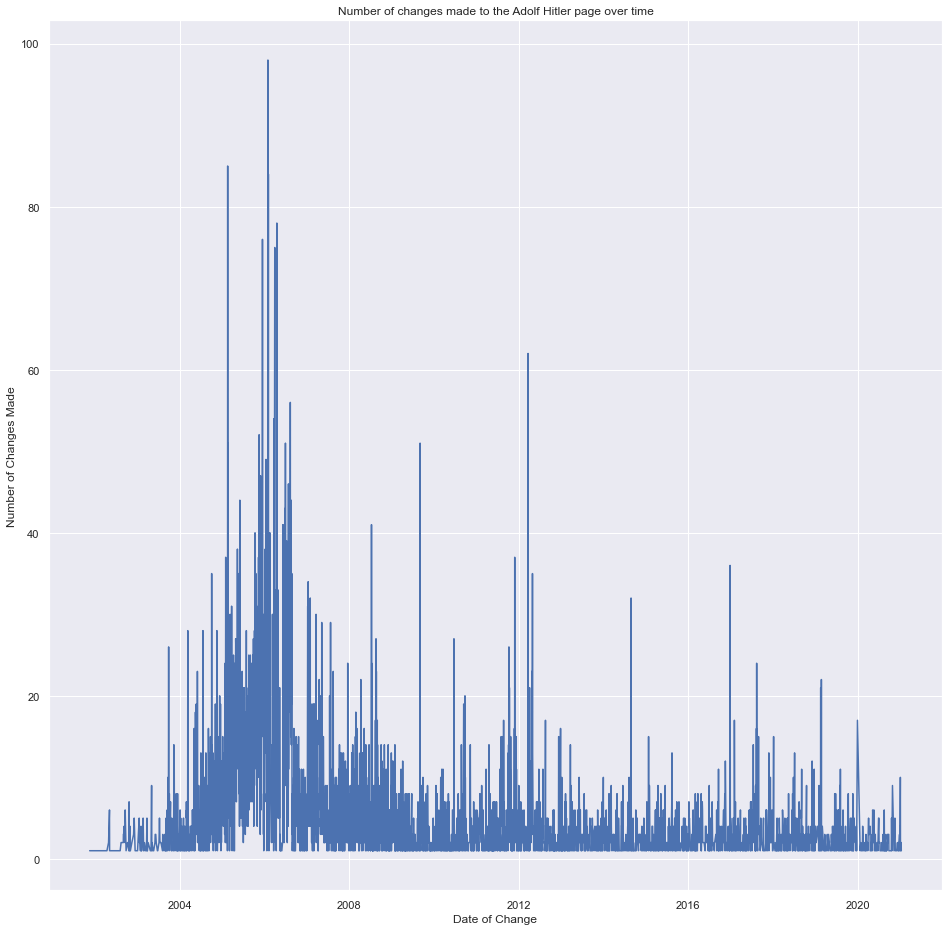

In [211]:
group_by = just_hitler.groupby(['Date of Change Reduced'])['User'].count()
group_by.columns = ['count']
print(type(group_by))

sns.set(rc={'figure.figsize':(16, 16)}) 
ax = sns.lineplot(data = group_by)
ax.set(ylabel='Number of Changes Made', xlabel='Date of Change', title='Number of changes made to the Adolf Hitler page over time')
plt.show()
# Who is making all of those edits to the Adolf Hitler page in 2006? Why are there still peaked days in 2012?
# What kinds of edits are being made? 